Matplotlib is building the font cache; this may take a moment.


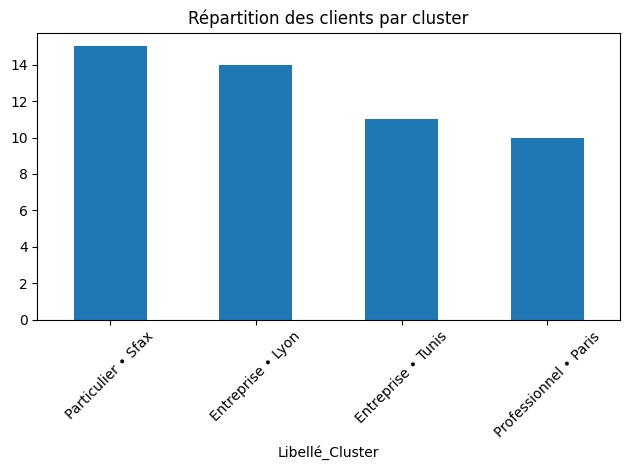

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("clients_segmentes.csv")
df["Libellé_Cluster"].value_counts().plot(kind="bar", rot=45)
plt.title("Répartition des clients par cluster"); plt.tight_layout(); plt.show()

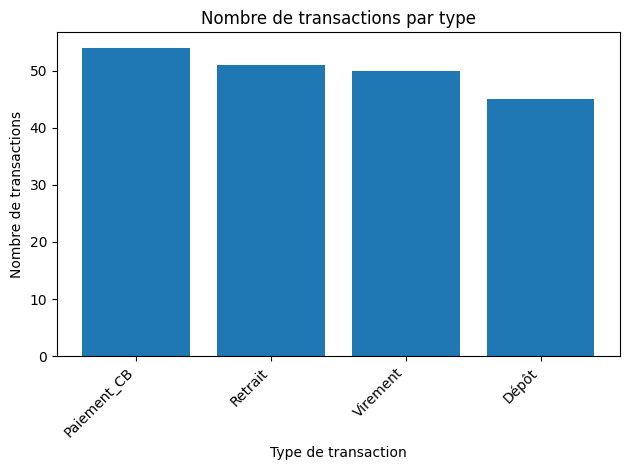

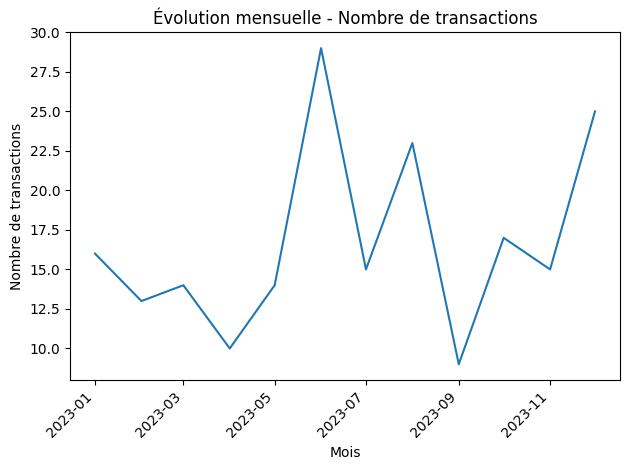

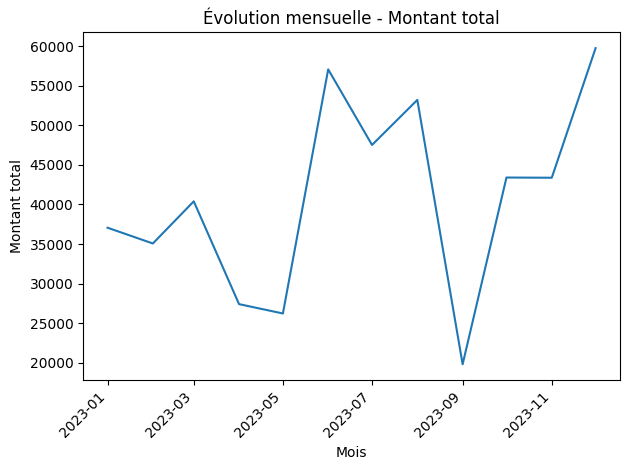

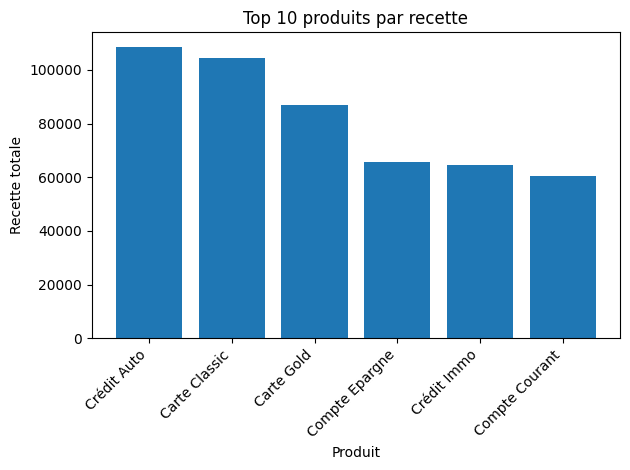

[OK] Exports créés : tx_by_type.csv, tx_monthly.csv, top_products.csv, tx_by_segment.csv


In [3]:
# -*- coding: utf-8 -*-
# bankia_eda.py
# EDA + visualisations pour Bankia (transactions, produits, segments)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- FICHIERS (dans le même dossier que ce script) ----------
XLSX_PATH = Path("Dataset_Bankia2025.xlsx")  # 4 feuilles: Agences, Produits_Bancaires, Transactions, Depenses
CSV_CLIENTS = Path("Clients.csv")            # colonnes: ID_Client, Nom_Client, Prenom_Client, Email, Téléphone, Ville, Pays, Segment_Client

# ---------- CHARGEMENT ----------
if not XLSX_PATH.exists():
    raise FileNotFoundError(f"Fichier introuvable: {XLSX_PATH.resolve()}")
if not CSV_CLIENTS.exists():
    raise FileNotFoundError(f"Fichier introuvable: {CSV_CLIENTS.resolve()}")

x = pd.ExcelFile(XLSX_PATH)
sheet_names = set(x.sheet_names)
required = {"Agences", "Produits_Bancaires", "Transactions", "Depenses"}
missing = required - sheet_names
if missing:
    raise ValueError(f"Feuilles manquantes dans l'Excel: {missing}")

agences = pd.read_excel(x, "Agences")
produits = pd.read_excel(x, "Produits_Bancaires")
transactions = pd.read_excel(x, "Transactions")
depenses = pd.read_excel(x, "Depenses")
clients = pd.read_csv(CSV_CLIENTS, encoding="utf-8")

# ---------- NETTOYAGE MINIMAL ----------
def clean_str_df(df: pd.DataFrame) -> pd.DataFrame:
    for c in df.columns:
        if df[c].dtype == object:
            df[c] = df[c].astype(str).str.strip()
    return df

for df in [agences, produits, transactions, depenses, clients]:
    clean_str_df(df)

# types et formats
if "Date_Transaction" in transactions.columns:
    transactions["Date_Transaction"] = pd.to_datetime(transactions["Date_Transaction"], errors="coerce")
if "Montant" in transactions.columns:
    transactions["Montant"] = pd.to_numeric(transactions["Montant"], errors="coerce")

# Standardise ville/pays si présents
for df in [agences, clients]:
    for c in ["Ville", "Pays"]:
        if c in df.columns:
            df[c] = df[c].str.title()

# ---------- AGRÉGATS ----------
# 1) Transactions par type
tx_by_type = (transactions
              .groupby("Type_Transaction", as_index=False)
              .agg(Nb_Tx=("ID_Transaction", "count"),
                   Montant_Total=("Montant", "sum"))
              .sort_values("Nb_Tx", ascending=False))

# 2) Tendances mensuelles (count & sum)
if "Date_Transaction" in transactions.columns and transactions["Date_Transaction"].notna().any():
    transactions["YearMonth"] = transactions["Date_Transaction"].dt.to_period("M").dt.to_timestamp()
    tx_monthly = (transactions
                  .groupby("YearMonth", as_index=False)
                  .agg(Nb_Tx=("ID_Transaction", "count"),
                       Montant_Total=("Montant", "sum"))
                  .sort_values("YearMonth"))
else:
    tx_monthly = pd.DataFrame(columns=["YearMonth", "Nb_Tx", "Montant_Total"])

# 3) Top produits par recette
tx_prod = transactions.merge(
    produits[["ID_Produit", "Nom_Produit", "Catégorie"]],
    on="ID_Produit", how="left"
)
top_products = (tx_prod.groupby(["ID_Produit", "Nom_Produit", "Catégorie"], as_index=False)
                .agg(Recette=("Montant", "sum"))
                .sort_values("Recette", ascending=False)
                .head(10))

# 4) Transactions par segment client
tx_client = transactions.merge(clients[["ID_Client", "Segment_Client"]], on="ID_Client", how="left")
tx_by_segment = (tx_client.groupby("Segment_Client", as_index=False)
                 .agg(Nb_Tx=("ID_Transaction", "count"),
                      Montant_Total=("Montant", "sum"))
                 .sort_values("Montant_Total", ascending=False))

# ---------- VISUALISATIONS (matplotlib pur, 1 figure par graphique) ----------
# Graphique 1 : Nombre de transactions par type
plt.figure()
if not tx_by_type.empty:
    plt.bar(tx_by_type["Type_Transaction"], tx_by_type["Nb_Tx"])
    plt.title("Nombre de transactions par type")
    plt.xlabel("Type de transaction")
    plt.ylabel("Nombre de transactions")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
else:
    plt.text(0.5, 0.5, "Pas de données pour 'Type_Transaction'", ha="center")
    plt.axis("off")
plt.show()

# Graphique 2 : Tendance mensuelle (Nb_Tx)
plt.figure()
if not tx_monthly.empty:
    plt.plot(tx_monthly["YearMonth"], tx_monthly["Nb_Tx"])
    plt.title("Évolution mensuelle - Nombre de transactions")
    plt.xlabel("Mois")
    plt.ylabel("Nombre de transactions")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
else:
    plt.text(0.5, 0.5, "Pas de données mensuelles", ha="center")
    plt.axis("off")
plt.show()

# Graphique 3 : Tendance mensuelle (Montant_Total)
plt.figure()
if not tx_monthly.empty:
    plt.plot(tx_monthly["YearMonth"], tx_monthly["Montant_Total"])
    plt.title("Évolution mensuelle - Montant total")
    plt.xlabel("Mois")
    plt.ylabel("Montant total")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
else:
    plt.text(0.5, 0.5, "Pas de données mensuelles", ha="center")
    plt.axis("off")
plt.show()

# Graphique 4 : Top 10 produits par recette
plt.figure()
if not top_products.empty:
    plt.bar(top_products["Nom_Produit"], top_products["Recette"])
    plt.title("Top 10 produits par recette")
    plt.xlabel("Produit")
    plt.ylabel("Recette totale")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
else:
    plt.text(0.5, 0.5, "Pas de données produits", ha="center")
    plt.axis("off")
plt.show()

# ---------- EXPORTS (pour Power BI si besoin) ----------
OUT_DIR = Path(".")
tx_by_type.to_csv(OUT_DIR / "tx_by_type.csv", index=False)
tx_monthly.to_csv(OUT_DIR / "tx_monthly.csv", index=False)
top_products.to_csv(OUT_DIR / "top_products.csv", index=False)
tx_by_segment.to_csv(OUT_DIR / "tx_by_segment.csv", index=False)

print("[OK] Exports créés : tx_by_type.csv, tx_monthly.csv, top_products.csv, tx_by_segment.csv")


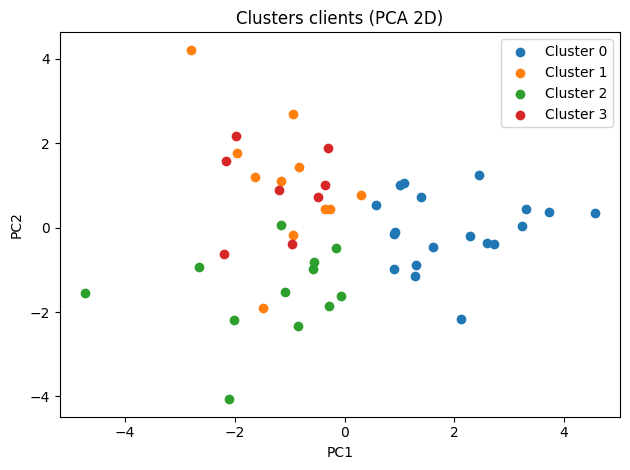

[OK] clients_clusters.csv créé


In [4]:
# Segmentation K-Means

# --- Segmentation KMeans + PCA (à exécuter après la section EDA) ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Recalcule/assure les agrégats client nécessaires
# (RFM + mix type/catégorie) à partir de `transactions`, `produits`, `clients`

tx = transactions.dropna(subset=["ID_Client", "Montant", "Date_Transaction"]).copy()
tx["Montant"] = pd.to_numeric(tx["Montant"], errors="coerce").fillna(0)
tx["Date_Transaction"] = pd.to_datetime(tx["Date_Transaction"], errors="coerce")

# Récence / fréquence / montant
ref_date = tx["Date_Transaction"].max() + pd.Timedelta(days=1)
agg_num = (tx.groupby("ID_Client")
             .agg(Tx_Count=("ID_Transaction", "count"),
                  Tx_Sum=("Montant", "sum"),
                  Tx_Mean=("Montant", "mean"),
                  Derniere_Tx=("Date_Transaction","max"))
             .reset_index())
agg_num["Recency_Jours"] = (ref_date - agg_num["Derniere_Tx"]).dt.days

# Fréquence mensuelle
tx["YearMonth"] = tx["Date_Transaction"].dt.to_period("M")
freq_mois = (tx.groupby(["ID_Client", "YearMonth"])["ID_Transaction"]
               .count().reset_index(name="Tx_Month_Count"))
freq_summary = (freq_mois.groupby("ID_Client")["Tx_Month_Count"]
                .agg(Freq_Moy="mean", Freq_Max="max").reset_index())

# Mix par type de transaction
mix_type = (tx.pivot_table(index="ID_Client", columns="Type_Transaction",
                           values="ID_Transaction", aggfunc="count", fill_value=0))
mix_type = mix_type.div(mix_type.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)
mix_type.columns = [f"Type__{c}" for c in mix_type.columns]
mix_type = mix_type.reset_index()

# Mix par catégorie de produit
txp = tx.merge(produits[["ID_Produit","Catégorie"]], on="ID_Produit", how="left")
mix_cat = (txp.pivot_table(index="ID_Client", columns="Catégorie",
                           values="ID_Transaction", aggfunc="count", fill_value=0))
mix_cat = mix_cat.div(mix_cat.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)
mix_cat.columns = [f"Cat__{c}" for c in mix_cat.columns]
mix_cat = mix_cat.reset_index()

# Merge features
features = clients[["ID_Client","Segment_Client"]].merge(agg_num.drop(columns=["Derniere_Tx"]),
                    on="ID_Client", how="left")
features = features.merge(freq_summary, on="ID_Client", how="left")
features = features.merge(mix_type, on="ID_Client", how="left")
features = features.merge(mix_cat,  on="ID_Client", how="left")

# Remplissage 0 pour clients sans historique
for c in ["Tx_Count","Tx_Sum","Tx_Mean","Recency_Jours","Freq_Moy","Freq_Max"]:
    if c in features.columns:
        features[c] = features[c].fillna(0)
mix_cols = [c for c in features.columns if c.startswith("Type__") or c.startswith("Cat__")]
features[mix_cols] = features[mix_cols].fillna(0)

# Numériques pour KMeans
num_cols = ["Tx_Count","Tx_Sum","Tx_Mean","Recency_Jours","Freq_Moy","Freq_Max"] + mix_cols
X = features[num_cols].copy()

# Sécurité si pas assez de lignes
if len(X) < 5:
    print("Données insuffisantes pour KMeans (min ~5).")
else:
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    k = 4 if len(X) >= 40 else 3
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
    features["Cluster"] = kmeans.fit_predict(Xs)

    # PCA 2D pour visualisation
    pca = PCA(n_components=2, random_state=42)
    pts = pca.fit_transform(Xs)
    features["PC1"] = pts[:,0]
    features["PC2"] = pts[:,1]

    # Scatter 2D (une figure dédiée)
    plt.figure()
    for cl in sorted(features["Cluster"].unique()):
        mask = features["Cluster"] == cl
        plt.scatter(features.loc[mask, "PC1"], features.loc[mask, "PC2"], label=f"Cluster {cl}")
    plt.title("Clusters clients (PCA 2D)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Export des clusters
    features_out = features[["ID_Client","Segment_Client","Cluster","PC1","PC2"] + num_cols]
    features_out.to_csv("clients_clusters.csv", index=False)
    print("[OK] clients_clusters.csv créé")


MAE: 0.167 | R²: 0.630


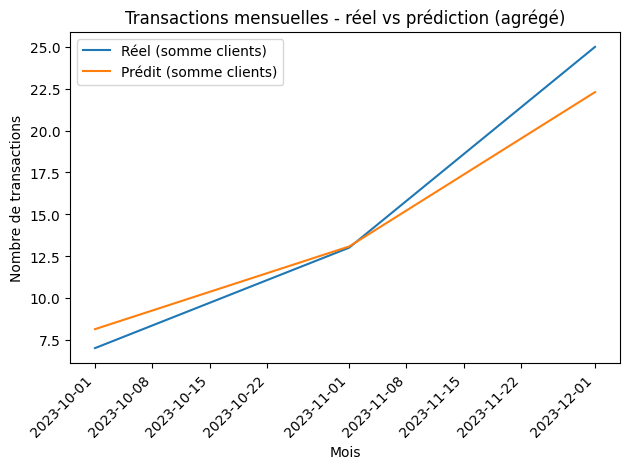

[OK] predictions_clients.csv & kpi_modele_pred.csv créés


In [5]:
# Prédiction « transactions du mois suivant » (RandomForest)

# --- Prédiction du nombre de transactions le mois suivant ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Table mensuelle par client déjà créée : freq_mois (ID_Client, YearMonth, Tx_Month_Count)
panel = freq_mois.copy()
panel["YearMonth"] = panel["YearMonth"].dt.to_timestamp()
panel = panel.sort_values(["ID_Client","YearMonth"])

# Features temporelles simples
panel["Lag1"] = panel.groupby("ID_Client")["Tx_Month_Count"].shift(1)
panel["RollMean3"] = panel.groupby("ID_Client")["Tx_Month_Count"].rolling(3).mean().reset_index(0,drop=True)

# On prédit Tx_Month_Count (t) à partir de t-1 (Lag1) et MM3 (t-1)
panel = panel.dropna(subset=["Lag1","RollMean3"])
panel["Target"] = panel["Tx_Month_Count"]

# Split temporel global : garde ~2 mois pour test
months = sorted(panel["YearMonth"].unique())
if len(months) < 4:
    print("Données mensuelles insuffisantes pour un split train/test.")
    rf = None
else:
    split_date = months[-3]
    train = panel[panel["YearMonth"] < split_date]
    test  = panel[panel["YearMonth"] >= split_date]

    X_train = train[["Lag1","RollMean3"]]
    y_train = train["Target"]
    X_test  = test[["Lag1","RollMean3"]]
    y_test  = test["Target"]

    rf = RandomForestRegressor(n_estimators=300, random_state=42)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2  = r2_score(y_test, y_pred)
    print(f"MAE: {mae:.3f} | R²: {r2:.3f}")

    # Courbe réelle vs prédite (agrégée tous clients)
    agg_test = test.groupby("YearMonth")["Target"].sum().reset_index()
    agg_pred = pd.DataFrame({"YearMonth": test["YearMonth"], "Pred": y_pred}).groupby("YearMonth")["Pred"].sum().reset_index()

    plt.figure()
    plt.plot(agg_test["YearMonth"], agg_test["Target"], label="Réel (somme clients)")
    plt.plot(agg_pred["YearMonth"], agg_pred["Pred"], label="Prédit (somme clients)")
    plt.title("Transactions mensuelles - réel vs prédiction (agrégé)")
    plt.xlabel("Mois")
    plt.ylabel("Nombre de transactions")
    plt.xticks(rotation=45, ha="right")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Inférence : prédire le prochain mois par client à partir de la dernière fenêtre dispo
    last_by_client = panel.sort_values(["ID_Client","YearMonth"]).groupby("ID_Client").tail(1)
    last_by_client["Pred_Next_Month_Tx"] = rf.predict(last_by_client[["Lag1","RollMean3"]])
    last_by_client["Risque_Inactivite_Prochain_Mois"] = np.where(last_by_client["Pred_Next_Month_Tx"] < 0.5, "Élevé", "Normal")

    # Export résultats client + KPI modèle
    last_by_client[["ID_Client","YearMonth","Lag1","RollMean3","Pred_Next_Month_Tx","Risque_Inactivite_Prochain_Mois"]] \
        .rename(columns={"YearMonth":"Dernier_Mois_Observe"}) \
        .to_csv("predictions_clients.csv", index=False)
    pd.DataFrame([{"MAE": mae, "R2": r2}]).to_csv("kpi_modele_pred.csv", index=False)

    print("[OK] predictions_clients.csv & kpi_modele_pred.csv créés")
